# News Classification

# 1. Frame the Problem

System requirements
1. Develop a web to let user qury news with the specified number and random categories (which the quried news would come from free news API named Mediastack)
2. The web must show actual and predicted categories corresponding to the queried news

Frame the problem based on the above requirements
1. The dataset for training model to predict news category is the [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset)
2. Since the live deployed system uses news Mediastack API, so the categories that both the dataset and the API available for would be 6 categories as shown below:
    * business
    * entertainment
    * health
    * science
    * sports
    * technology
3. Since there are multiple categories to predict, so the model task must be the type of multiclass classification

# Set up

In [1]:
!pip install nlpaug==1.1.11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.2 MB/s eta 0:00:00:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nlpaug.augmenter.word as naw
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

from pathlib import Path
import json
from math import ceil
from random import choices
import re
from tqdm import tqdm
import joblib
from pprint import pprint

nltk.download('averaged_perceptron_tagger_eng')

2025-08-27 09:52:36.025327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756288356.394504      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756288356.501037      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# 2. Get the Data

In [3]:
with open('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', 'r') as f:
    news_dict_ls = []
    cat_ls = []
    
    for news_dict_str in f:
        news_dict = json.loads(news_dict_str)
        news_dict_ls.append(news_dict)

        if not(news_dict['category'] in cat_ls):
            cat_ls.append(news_dict['category'])

# 3. Explore the Data

In [47]:
# news_dict_ls

news_dict_ls[0: 5]

[{'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9',
  'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters',
  'category': 'U.S. NEWS',
  'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.',
  'authors': 'Carla K. Johnson, AP',
  'date': '2022-09-23'},
 {'link': 'https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe',
  'headline': 'American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video',
  'category': 'U.S. NEWS',
  'short_description': "He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",
  'authors': 'Mary Papenfuss',
  'date': '2022-09-23'},
 {'link': 'https

In [5]:
print('len(news_dict_ls) =', len(news_dict_ls))
print()
print('cat_ls =', cat_ls)
print()
print('news_dict_ls[0] = \n', news_dict_ls[0])

len(news_dict_ls) = 209527

cat_ls = ['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS', 'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS', 'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS', 'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA', 'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL', 'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS', 'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS', 'DIVORCE']

news_dict_ls[0] = 
 {'link': 'https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9', 'headline': 'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters', 'category': 'U.S. NEWS', 'short_description': 'Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.', 'authors': 'Carla K. J

*-----------------------------------------------------------------------------------------------------------------------------------------------------------

## Short Cut

At first, the dataframe and the df.json file from the original dataset are builded at the step 1 (currently, it is the step 3) of the section 4. Prepare the Data. Then later, exploring class imbalanceness is conducted in this section. So, the below cell loading dataframe from the saved df.json file acts as a necessary short cut.

In [6]:
df = pd.read_json('/kaggle/working/df.json')

df

,news,category
0,Twitch Bans Gambling Sites After Streamer Scam...,technology
1,"Maury Wills, Base-Stealing Shortstop For Dodge...",sports
2,Golden Globes Returning To NBC In January Afte...,entertainment
3,"Las Vegas Aces Win First WNBA Title, Chelsea G...",sports
4,James Cameron Says He 'Clashed' With Studio Be...,entertainment
...,...,...
39430,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,technology
39431,Maria Sharapova Stunned By Victoria Azarenka I...,sports
39432,"Giants Over Patriots, Jets Over Colts Among M...",sports
39433,Aldon Smith Arrested: 49ers Linebacker Busted ...,sports


*-----------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
word_counts = df['news'].str.findall(r'\S+').str.len()

wc_flt = (word_counts == 1)
wc_1_inds = word_counts[wc_flt].index

print('word_counts.min() =', word_counts.min())
print('word_counts.max() =', word_counts.max())
print('word_counts.median() =', word_counts.median())
df.iloc[wc_1_inds, :]

word_counts.min() = 1
word_counts.max() = 176
word_counts.median() = 24.0


,news,category
24256,SPLIT!.,sports
24667,Into-Me-See.,health
25574,#Anxiety.,health
26630,.,business
30132,BANKRUPT.,business
30175,8:00.,health
30391,CUT.,sports
31745,ARRESTED.,entertainment
32667,R.I.P..,entertainment
32806,Bareback.,health


## Check on Imbalance among Classes

Percentage proportion of individual category over entire dataset

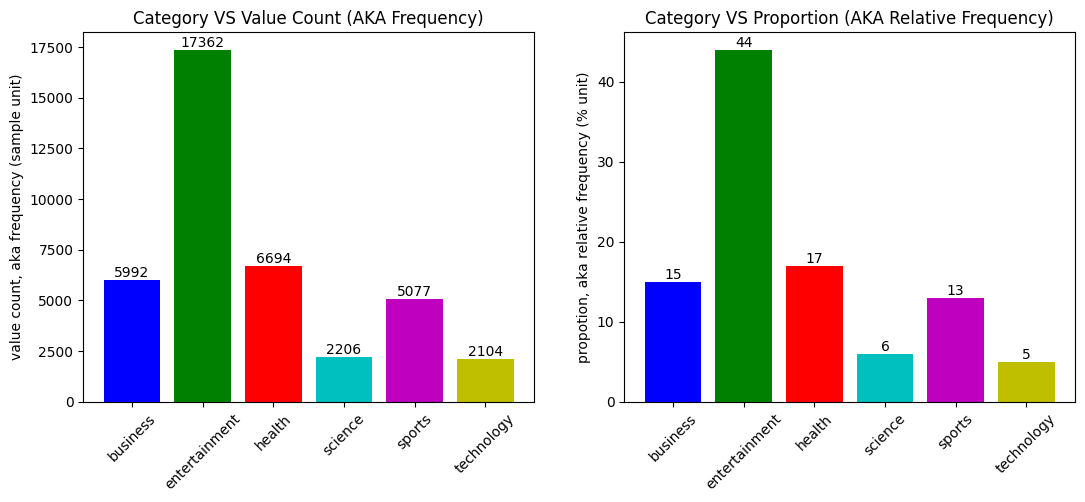

In [8]:
bar_x_axis = df['category'].unique()
bar_x_axis = np.sort(bar_x_axis)

f_ser = df['category'].value_counts()
f_ser = f_ser.sort_index()
f_lst = list(f_ser)

rf_ser = df['category'].value_counts(normalize=True) * 100
rf_ser = rf_ser.sort_index()
rf_lst = list(rf_ser)
rf_lst = [round(rf) for rf in rf_lst]

fig, ax = plt.subplots(1, 2, figsize=[6.4*2, 4.8])
bar_corlors = ['b', 'g', 'r', 'c', 'm', 'y'] 

bar_obj0 = ax[0].bar(bar_x_axis, f_lst, color=bar_corlors)
ax[0].set_title('Category VS Value Count (AKA Frequency)')
ax[0].set_ylabel('value count, aka frequency (sample unit)')
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].bar_label(bar_obj0)

bar_obj1 = ax[1].bar(bar_x_axis, rf_lst, color=bar_corlors)
ax[1].set_title('Category VS Proportion (AKA Relative Frequency)')
ax[1].set_ylabel('propotion, aka relative frequency (% unit)')
ax[1].tick_params(axis='x', labelrotation=45)
ax[1].bar_label(bar_obj1)

plt.show()
fig.savefig('/kaggle/working/barchart1.png', bbox_inches = 'tight')

Mannually adjust augmentation rate (ie., aug_num_lst) to determine augmentation numbers corresponding to class balanceness

In [9]:
valAscOrd_f_lst = list(df['category'].value_counts())
valAscOrd_rf_lst = df['category'].value_counts(normalize=True) * 100
valAscOrd_rf_lst = list(round(valAscOrd_rf_lst, ndigits=0))
catInd_4_valAscOrd = list(df['category'].value_counts().index)
aug_rate_lst = [1, 2.5, 2.5, 3, 6.5, 6.5]

# resample_f_lst and resample_rf_lst frequencies in value-ascending order
resample_f_lst = [f*aug_rate for f, aug_rate in zip(valAscOrd_f_lst, aug_rate_lst)]
resample_rf_lst = [(f / sum(resample_f_lst))*100 for f in resample_f_lst]
resample_rf_lst = [round(rf) for rf in resample_rf_lst]

aug_num_lst = [resam_f - f for resam_f, f in zip(resample_f_lst, valAscOrd_f_lst)]

print('catInd_4_valAscOrd =', catInd_4_valAscOrd)
print()
print('f_lst (value-ascending order) =', valAscOrd_f_lst)
print('rf_lst (value-ascending order) =', valAscOrd_rf_lst, '%')
print()
print('Augentation rate = ', aug_rate_lst)
print()
print('resample_f_lst (value-ascending order) =', resample_f_lst)
print('resample_rf_lst (value-ascending order) =', resample_rf_lst, '%')
print()
print('aug_num_lst =', aug_num_lst)

catInd_4_valAscOrd = ['entertainment', 'health', 'business', 'sports', 'science', 'technology']

f_lst (value-ascending order) = [17362, 6694, 5992, 5077, 2206, 2104]
rf_lst (value-ascending order) = [44.0, 17.0, 15.0, 13.0, 6.0, 5.0] %

Augentation rate =  [1, 2.5, 2.5, 3, 6.5, 6.5]

resample_f_lst (value-ascending order) = [17362, 16735.0, 14980.0, 15231, 14339.0, 13676.0]
resample_rf_lst (value-ascending order) = [19, 18, 16, 16, 16, 15] %

aug_num_lst = [0, 10041.0, 8988.0, 10154, 12133.0, 11572.0]


Rounding at the place value of thousands for getting numbers that are easy to remember

In [10]:
# Rounding at the place value of thousands for getting numbers that are easy to remember
ThRound_resample_f_lst = [round(f, -2) for f in resample_f_lst] # ThRound stands for thousand round
ThRound_resample_rf_lst = [(f / sum(ThRound_resample_f_lst))*100 for f in ThRound_resample_f_lst]
ThRound_resample_rf_lst = [round(rf) for rf in ThRound_resample_rf_lst]

aug_num_lst2 = [resam_f - f for resam_f, f in zip(ThRound_resample_f_lst, valAscOrd_f_lst)]

print('catInd_4_valAscOrd =', catInd_4_valAscOrd)
print()
print('ThRound_resample_f_lst =', ThRound_resample_f_lst)
print('ThRound_resample_rf_lst =', ThRound_resample_rf_lst, '%')
print()
print('aug_num_lst2 =', aug_num_lst2)
print()
print('Tota data after augmentation =', sum(ThRound_resample_f_lst))

catInd_4_valAscOrd = ['entertainment', 'health', 'business', 'sports', 'science', 'technology']

ThRound_resample_f_lst = [17400, 16700.0, 15000.0, 15200, 14300.0, 13700.0]
ThRound_resample_rf_lst = [19, 18, 16, 16, 15, 15] %

aug_num_lst2 = [38, 10006.0, 9008.0, 10123, 12094.0, 11596.0]

Tota data after augmentation = 92300.0


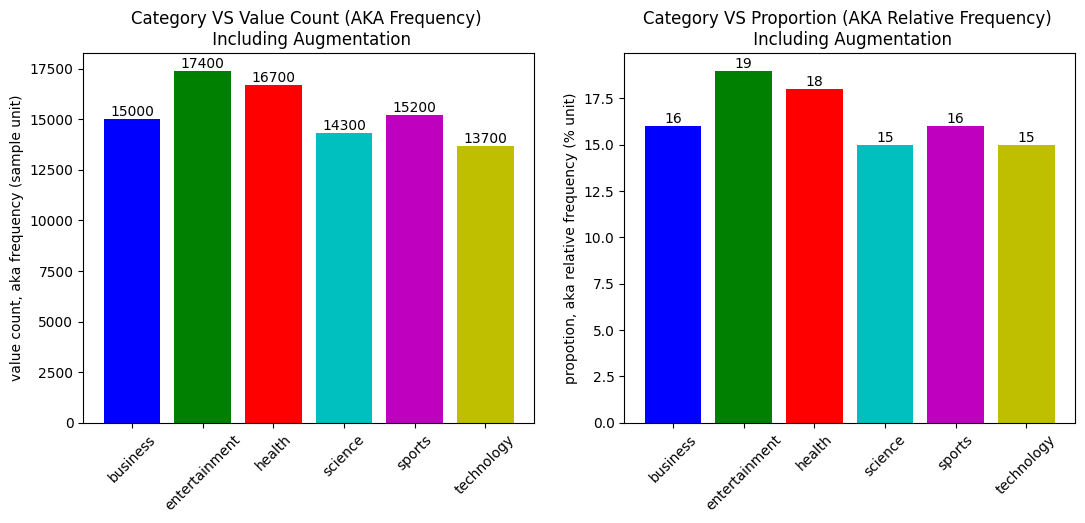

aug_num_lst2 (category-ascending order) = [9008.0, 38.0, 10006.0, 12094.0, 10123.0, 11596.0]

Tota data after augmentation = 92300.0


In [11]:
# ThRound_resample_f_lst stores frequencies in value-ascending order, not in category-ascending order.
ThRound_resample_f_ser = pd.Series(ThRound_resample_f_lst, index=catInd_4_valAscOrd)
ThRound_resample_rf_ser = pd.Series(ThRound_resample_rf_lst, index=catInd_4_valAscOrd)

fig1, ax1 = plt.subplots(1, 2, figsize=[6.4*2, 4.8])

bar_obj10 = ax1[0].bar(bar_x_axis, ThRound_resample_f_ser.sort_index(), color=bar_corlors)
# title10=''
ax1[0].set_title('Category VS Value Count (AKA Frequency) \n Including Augmentation')
ax1[0].set_ylabel('value count, aka frequency (sample unit)')
ax1[0].tick_params(axis='x', labelrotation=45)
ax1[0].bar_label(bar_obj10)

bar_obj11 = ax1[1].bar(bar_x_axis, ThRound_resample_rf_ser.sort_index(), color=bar_corlors)
ax1[1].set_title('Category VS Proportion (AKA Relative Frequency) \n Including Augmentation')
ax1[1].set_ylabel('propotion, aka relative frequency (% unit)')
ax1[1].tick_params(axis='x', labelrotation=45)
ax1[1].bar_label(bar_obj11)

plt.show()
fig1.savefig('/kaggle/working/barchart2.png', bbox_inches = 'tight')

aug_num_ser2 = pd.Series(aug_num_lst2, index=catInd_4_valAscOrd)
catAscOrd_aug_num_lst2 = list(aug_num_ser2.sort_index())
print('aug_num_lst2 (category-ascending order) =', catAscOrd_aug_num_lst2)
print()
print('Tota data after augmentation =', sum(ThRound_resample_f_lst))

# 4. Prepare the Data

Rough steps for preparing data:

1. Perform text augmentation using sysnonym replacement method

2. Rewrite the dataset's target catgories to have the same writting-format as the ones from the news API

   E.g., "HEALTHY LIVING", which is the dataset's target catgory, should be rewritten to be 'health'

4. Build the two dataframes for the original dataset and the full-augemented dataset (both containing instances with the target catgories)

5. Split datasets

6. Extract TF-IDF feature from the text inside the two dataframes

7. Encode categorical labels

## Step 1 Text Augmentation using Synonym Replacement Technique

Determine parameters to perform synonym replacement based-on the original dataset

                        f_org * s_i = f_aug 
                        
                        where - f_org denotes sample frequency (ie, total texts) of an invidual  
                                class from the original dataset
                              
                              - f_aug denotes sample frequency (ie, total texts) of an invidual  
                                class from the new-generated/augmented dataset (excluding the 
                                original dataset)
                              
                              - s_i denotes number of sysnonym words being used on an invidual 
                                text for augmentatinon

                        For the class 0 (business); 5,592 * s_0 = 9,008
                                                            s_0 = 9,008 / 5,592
                                                                ≈ ⌈1.50⌉ 
                                                            s_0 ≈ 2

                        For the class 1 (entertainment); 17,362 * s_1 = 38
                                                                  s_1 = 38 / 17,362
                                                                      ≈ ⌈0.00219⌉ 
                                                                  s_1 ≈ 1

                        For the class 2 (health); 6,694 * s_2 = 10,006
                                                          s_2 = 10,006 / 6,694 
                                                              ≈ ⌈1.49⌉ 
                                                          s_2 ≈ 2

                        For the class 3 (science); 2,206 * s_3 = 12,094
                                                           s_3 = 12,094 / 2,206
                                                               ≈ ⌈5.48⌉ 
                                                           s_3 ≈ 6

                        For the class 4 (sports); 5,077 * s_4 = 10,123
                                                          s_4 = 10,123 / 5,077
                                                              ≈ ⌈1.99⌉ 
                                                          s_4 ≈ 2

                        For the class 5 (technology); 2,104 * s_5 = 11,596
                                                              s_5 = 11,596 / 2,104
                                                                  ≈ ⌈5.51⌉ 
                                                              s_5 ≈ 6

                        Summary: consider the length of both news title and short description 
                        using to train the model and the necessary numbers of sysnonym words 
                        determined above, it is promising to use synonym replacement technique 
                        with the above paremeter to archive augmenting dataset with the target
                        number to tackle class imbalanceness.

Define function for text augmentation

In [12]:
def augment_txts(txts, aug_num):
    org_f = len(txts)
    aug_f = aug_num
    syn_word_num = ceil(aug_f / org_f)
    augNum_per_txt = syn_word_num
    
    aug = naw.SynonymAug(aug_min=syn_word_num, aug_max=syn_word_num)
    aug_corpus = []
    print('aug_f =', aug_f)
    
    for txt in tqdm(txts):
        aug_txts = aug.augment(txt, augNum_per_txt) # aug_txts is a list of augmented texts

        aug_corpus += aug_txts
        
        if len(aug_corpus) >= aug_num:
            
            if len(aug_corpus) > aug_num:
                cut_num = len(aug_corpus) - aug_num
                aug_corpus = aug_corpus[0: (-1 * cut_num)]

            break
    
    return aug_corpus

Define lists containing individual class X attribute (i.e., text) of the original dataset

In [13]:
class0_flt = (df['category'] == 'business')
class1_flt = (df['category'] == 'entertainment')
class2_flt = (df['category'] == 'health')
class3_flt = (df['category'] == 'science')
class4_flt = (df['category'] == 'sports')
class5_flt = (df['category'] == 'technology')


X = df['news']
class0_X = df[class0_flt]['news']
class1_X = df[class1_flt]['news']
class2_X = df[class2_flt]['news']
class3_X = df[class0_flt]['news']
class4_X = df[class1_flt]['news']
class5_X = df[class2_flt]['news']

class0_X_lst = list(class0_X)
class1_X_lst = list(class1_X)
class2_X_lst = list(class2_X)
class3_X_lst = list(class3_X)
class4_X_lst = list(class4_X)
class5_X_lst = list(class5_X)

y = df['category'].unique()
y = np.sort(y)

print(y)
print()
print(class0_X)
print()
print(class1_X)

['business' 'entertainment' 'health' 'science' 'sports' 'technology']

39       REI Workers At Berkeley Store Vote To Unionize...
87       Twitter Lawyer Calls Elon Musk 'Committed Enem...
161      Starbucks Leaving Russian Market, Shutting 130...
175      Crypto Crash Leaves Trading Platform Coinbase ...
177      US Added 428,000 Jobs In April Despite Surging...
                               ...                        
39418    Four More Bank Closures Mark the Week of Janua...
39419    Everything You Need To Know About Overdraft Fe...
39420    Walmart Waving Goodbye To Some Greeters. After...
39421    At World Economic Forum, Fear of Global Contag...
39422    Positive Customer Experience: What's the Retur...
Name: news, Length: 5992, dtype: object

2        Golden Globes Returning To NBC In January Afte...
4        James Cameron Says He 'Clashed' With Studio Be...
5        Amazon Greenlights 'Blade Runner 2099' Limited...
6        'The Phantom Of The Opera' To Close On Broadwa...
7  

Define lists containing individual class X attribute (i.e., text) of the augmented dataset (only augmented text without its original text)

In [14]:
%%time

'''
catAscOrd_aug_num_lst2 contain as the following order: business, entertainment
                                                       health, science
                                                       sports, technology
'''   

class0_aug_num = int(catAscOrd_aug_num_lst2[0])
class1_aug_num = int(catAscOrd_aug_num_lst2[1])
class2_aug_num = int(catAscOrd_aug_num_lst2[2])
class3_aug_num = int(catAscOrd_aug_num_lst2[3])
class4_aug_num = int(catAscOrd_aug_num_lst2[4])
class5_aug_num = int(catAscOrd_aug_num_lst2[5])

class0_aug_X_lst = augment_txts(class0_X_lst, aug_num=class0_aug_num)
class1_aug_X_lst = augment_txts(class1_X_lst, aug_num=class1_aug_num)
class2_aug_X_lst = augment_txts(class2_X_lst, aug_num=class2_aug_num)
class3_aug_X_lst = augment_txts(class3_X_lst, aug_num=class3_aug_num)
class4_aug_X_lst = augment_txts(class4_X_lst, aug_num=class4_aug_num)
class5_aug_X_lst = augment_txts(class5_X_lst, aug_num=class5_aug_num)

aug_f = 9008


 75%|███████▌  | 4503/5992 [00:11<00:03, 392.00it/s]


aug_f = 38


  0%|          | 37/17362 [00:00<00:26, 659.05it/s]


aug_f = 10006


 75%|███████▍  | 5002/6694 [00:11<00:03, 441.68it/s]


aug_f = 12094


 67%|██████▋   | 4031/5992 [00:14<00:07, 272.15it/s]


aug_f = 10123


 58%|█████▊    | 10122/17362 [00:11<00:08, 891.58it/s]


aug_f = 11596


 87%|████████▋ | 5797/6694 [00:12<00:02, 446.36it/s]

CPU times: user 1min 4s, sys: 374 ms, total: 1min 5s
Wall time: 1min 5s


In [15]:
print('aug_num_lst2 (category-ascending order) =', catAscOrd_aug_num_lst2)
print()
print('len(class0_aug_X_lst) =', len(class0_aug_X_lst))
print('len(class1_aug_X_lst) =', len(class1_aug_X_lst))
print('len(class2_aug_X_lst) =', len(class2_aug_X_lst))
print('len(class3_aug_X_lst) =', len(class3_aug_X_lst))
print('len(class4_aug_X_lst) =', len(class4_aug_X_lst))
print('len(class5_aug_X_lst) =', len(class5_aug_X_lst))

aug_num_lst2 (category-ascending order) = [9008.0, 38.0, 10006.0, 12094.0, 10123.0, 11596.0]

len(class0_aug_X_lst) = 9008
len(class1_aug_X_lst) = 38
len(class2_aug_X_lst) = 10006
len(class3_aug_X_lst) = 12094
len(class4_aug_X_lst) = 10123
len(class5_aug_X_lst) = 11596


In [16]:
aug_X_dict = {
    'class0_aug_X_lst': class0_aug_X_lst,
    'class1_aug_X_lst': class1_aug_X_lst,
    'class2_aug_X_lst': class2_aug_X_lst,
    'class3_aug_X_lst': class3_aug_X_lst,
    'class4_aug_X_lst': class4_aug_X_lst,
    'class5_aug_X_lst': class5_aug_X_lst,
}

with open('/kaggle/working/aug_X.json', 'w') as aug_X_f:
    json.dump(aug_X_dict, aug_X_f, indent=4)

## Steps 2-3. Rewriting The Dataset's Target Catgories and Building Dataframe

Rewrite the dataset's target catgories to have the same writting-format as the ones from news API.

E.g., "HEALTHY LIVING", which is the dataset's target catgory, should be rewritten to be 'health'.

In [18]:
def return_ind_tupple(og_ind, target_ind):
    return (og_ind, target_ind)

def concate_aug_data(df, augData_json_path):
    
    with open(augData_json_path, 'r') as json_f:
        aug_X_dict = json.load(json_f) 
        
    aug_df = None
    classes = ['business', 'entertainment', 'health', 'science', 'sports', 'technology'] # the 'classes' variable stores classes in category-ascending order. 
    
    for key, class_X_lst in aug_X_dict.items():
        class_ind = int(key[5]) # The 'key' variable stores key string inside the "aug_x_dict" that denotes class of augmented data, e.g., the first key is 'class0_aug_X_lst'.      
        class_list = [classes[class_ind]] * len(class_X_lst) # classes[class_ind] returns only an string (e.g., 'bussiness' etc.), but the expression [classes[class_ind]] * len(class_X_lst) returns a list of the specified-index class with the total elements equivalent to the total instances in the variable 'class_X_lst'. E.g., the class 0 business has 9008 instances in augment dataset, so the expression [classes[class_ind]] * len(class_X_lst) returns ['bussiness', ..., 'bussiness'] with 9008 elements.
        
        if aug_df is None:
            aug_df = pd.DataFrame({
                'news': class_X_lst,
                'category': class_list,
            })
            
        else:
            df_rows = pd.DataFrame({
                'news': class_X_lst,
                'category': class_list,
            })
            
            aug_df = pd.concat([aug_df, df_rows], ignore_index=True)
    
    full_df = pd.concat([df, aug_df], ignore_index=True)
    
    return full_df

# 1. Rewrite the dataset's target catgories
def rewrite_target_catgories(news_dict_ls, targetCat_2_newFormCat, verbose=False):
    ind = 0
    if verbose:
        rewrite_count = 0
        
    for news_dict in tqdm(news_dict_ls):
        
        if (news_dict['category'] in targetCat_2_newFormCat.keys()):
            
            key_2_newFormCat = news_dict['category']
            news_dict['category'] = targetCat_2_newFormCat[key_2_newFormCat]
            news_dict_ls[ind] = news_dict

            if verbose:
                rewrite_count += 1
            
        ind += 1

    if verbose:
        print('rewrite_count =', rewrite_count)

    return news_dict_ls

# 2. Build dataframe containing instances with the target catgories from the original dataset and containing the augmented dataset
def build_df_from_dicts(news_dict_ls, cat_ls, augData_json_path=None, verbose=False):
    full_df = None
    og_news_ind = 0
    selected_og_news_ind_ls = []
    ogNewsInd_2_targetNewsInd = {}
    
    for news_dict in tqdm(news_dict_ls):
        
        if news_dict['category'] in cat_ls:
            news_str = news_dict['headline'] + '. ' + news_dict['short_description']
    
            if full_df is None:
                full_df = pd.DataFrame({
                    'news': [news_str],
                    'category': [news_dict['category']],
                    }) 
            else:
                df_row = pd.DataFrame({
                    'news': [news_str],
                    'category': [news_dict['category']],
                    }) 
                
                full_df = pd.concat([full_df, df_row], ignore_index=True)
             
            selected_og_news_ind_ls.append(og_news_ind)
        
        og_news_ind += 1

    ogNewsInd_2_targetNewsInd.update(map(return_ind_tupple, selected_og_news_ind_ls, full_df.index)) # Excluding index for augmented data

    if not(augData_json_path is None):
        full_df = concate_aug_data(full_df, augData_json_path)
        aug_num = full_df.shape[0] - len(selected_og_news_ind_ls)
    
    if verbose:
        if augData_json_path == None:
            print('insert_count =', len(selected_og_news_ind_ls))
        else:
            print(f'insert_count (including {aug_num} augmented data) = {len(selected_og_news_ind_ls) + aug_num}')
    
    return full_df, ogNewsInd_2_targetNewsInd

In [19]:
# 1. Rewrite the dataset's target catgories
targetCat_2_newFormCat = {
    'BUSINESS': 'business',
    'ENTERTAINMENT': 'entertainment',
    'HEALTHY LIVING': 'health',
    'SCIENCE': 'science',
    'SPORTS': 'sports',
    'TECH': 'technology',
}
news_dict_ls2 = rewrite_target_catgories(news_dict_ls, targetCat_2_newFormCat=targetCat_2_newFormCat, verbose=True)

# 2. Build dataframe containing instances with the target catgories from the original dataset and containing the augmented dataset

#     df, ogNewsInd_2_targetNewsInd = build_df_from_dicts(news_dict_ls2, cat_ls=list(targetCat_2_newFormCat.values()), verbose=True) # insert_count = 39435 for this line
full_aug_df, ogNewsInd_2_targetNewsInd = build_df_from_dicts(news_dict_ls2, 
                                                             cat_ls=list(targetCat_2_newFormCat.values()), 
                                                             augData_json_path='/kaggle/working/aug_X.json', 
                                                             verbose=True) # insert_count = 92300 for this line

100%|██████████| 209527/209527 [00:00<00:00, 1411643.28it/s]


rewrite_count = 39435


100%|██████████| 209527/209527 [00:22<00:00, 9504.45it/s] 

insert_count (including 52865 augmented data) = 92300


In [20]:
# df

full_aug_df

,news,category
0,Twitch Bans Gambling Sites After Streamer Scam...,technology
1,"Maury Wills, Base-Stealing Shortstop For Dodge...",sports
2,Golden Globes Returning To NBC In January Afte...,entertainment
3,"Las Vegas Aces Win First WNBA Title, Chelsea G...",sports
4,James Cameron Says He 'Clashed' With Studio Be...,entertainment
...,...,...
92295,Here ' s One Matter That Make Lucid Dreamers D...,technology
92296,pentad Viruses That Be Scarier Than Ebola.,technology
92297,5 Virus That Are Scarier Than Ebola.,technology
92298,9 Important Things We Can Learn From The Young...,technology


In [49]:
print('len(ogNewsInd_2_targetNewsInd) =', len(ogNewsInd_2_targetNewsInd))

# ogNewsInd_2_targetNewsInd

print('Top 5 pairs of ogNewsInd_2_targetNewsInd =', list(ogNewsInd_2_targetNewsInd.items())[0: 5])

len(ogNewsInd_2_targetNewsInd) = 39435
Top 5 pairs of ogNewsInd_2_targetNewsInd = [(13, 0), (17, 1), (20, 2), (26, 3), (28, 4)]


In [22]:
# df.to_json('/kaggle/working/df.json', indent=4)

full_aug_df.to_json('/kaggle/working/full_aug_df2.json', indent=4)

with open('/kaggle/working/ogNewsInd_2_targetNewsInd2.json', 'w') as ogNewsInd_2_targetNewsInd_f:
    json.dump(ogNewsInd_2_targetNewsInd, ogNewsInd_2_targetNewsInd_f, indent=4)

*-----------------------------------------------------------------------------------------------------------------------------------------------------------

## Short Cut 2

Short-cut cell loading necessary data for skipping sections or steps that already performed in the past

In [3]:
df = pd.read_json('/kaggle/working/df.json')
full_aug_df = pd.read_json('/kaggle/working/full_aug_df.json')

# df
full_aug_df

,news,category
0,Twitch Bans Gambling Sites After Streamer Scam...,technology
1,"Maury Wills, Base-Stealing Shortstop For Dodge...",sports
2,Golden Globes Returning To NBC In January Afte...,entertainment
3,"Las Vegas Aces Win First WNBA Title, Chelsea G...",sports
4,James Cameron Says He 'Clashed' With Studio Be...,entertainment
...,...,...
92295,Here ' s One Matter That Make Lucid Dreamers D...,technology
92296,pentad Viruses That Be Scarier Than Ebola.,technology
92297,5 Virus That Are Scarier Than Ebola.,technology
92298,9 Important Things We Can Learn From The Young...,technology


*-----------------------------------------------------------------------------------------------------------------------------------------------------------

## Step 4. Splitting Data

Split the original dataset

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df['news'], df['category'], test_size=0.2, 
                                                    random_state=42)

#  All four variables defining above are pd.Series objects
print('x_train.shape =', x_train.shape)
print('x_test.shape =', x_test.shape)
print('y_train.shape =', y_train.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (31548,)
x_test.shape = (7887,)
y_train.shape = (31548,)
y_test.shape = (7887,)


Split the full-augmented dataset

In [25]:
fullAug_x_train, fullAug_x_test, fullAug_y_train, fullAug_y_test = train_test_split(full_aug_df['news'], 
                                                                                    full_aug_df['category'],
                                                                                    test_size=0.2, 
                                                                                    random_state=42)

#  All four variables defining above are pd.Series objects
print('fullAug_x_train.shape =', fullAug_x_train.shape)
print('fullAug_x_test.shape =', fullAug_x_test.shape)
print('fullAug_y_train.shape =', fullAug_y_train.shape)
print('fullAug_y_test.shape =', fullAug_y_test.shape)

fullAug_x_train.shape = (73840,)
fullAug_x_test.shape = (18460,)
fullAug_y_train.shape = (73840,)
fullAug_y_test.shape = (18460,)


## Step 5. Extracting TF-IDF Feature From the Text Inside the Dataframes

Extract TF-IDF from the original dataset

In [26]:
tfidf_transformer = TfidfVectorizer()

# Fit transformer on x_train and then immediately transform the data
prep_x_train = tfidf_transformer.fit_transform(x_train)

# Use the fitted transformer to transform test set, i.e., x_test
prep_x_test = tfidf_transformer.transform(x_test)

# show an example
print(prep_x_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 698193 stored elements and shape (31548, 36736)>
  Coords	Values
  (0, 1484)	0.1733103675746043
  (0, 6805)	0.13515093196228314
  (0, 10870)	0.22338532181300835
  (0, 14720)	0.1574388837156095
  (0, 19775)	0.17155004835718438
  (0, 32812)	0.036094773577699885
  (0, 19847)	0.10951330054747582
  (0, 6726)	0.21737375528819322
  (0, 15980)	0.26588042531232964
  (0, 32937)	0.1299996788737775
  (0, 10053)	0.3225093700270248
  (0, 22886)	0.04932423398363581
  (0, 31884)	0.22121634594635245
  (0, 1744)	0.10272106258251816
  (0, 1474)	0.24303959054985538
  (0, 2147)	0.1584041266676009
  (0, 32807)	0.1392701424224567
  (0, 23281)	0.14695919712483066
  (0, 36090)	0.07030407982273751
  (0, 7187)	0.19248293055237414
  (0, 35975)	0.3811775841197579
  (0, 3276)	0.08045280926848136
  (0, 36536)	0.07349508095153792
  (0, 33189)	0.27041269192481837
  (0, 34600)	0.0962032046783561
  :	:
  (31546, 1744)	0.05678264167954714
  (31546, 23030)	0.14

Extract TF-IDF from the full-augmented dataset

In [27]:
aug_tfidf_transformer = TfidfVectorizer()

# Fit transformer
aug_tfidf_transformer.fit(fullAug_x_train)

# Use the fitted transformer to transform data, i.e., fullAug_x_train and fullAug_x_test.
fullAugPrep_x_train = aug_tfidf_transformer.transform(fullAug_x_train) # fullAugPrep_x_train is np.array from now on.
fullAugPrep_x_test = aug_tfidf_transformer.transform(fullAug_x_test) # fullAugPrep_x_test is np.array from now on.

# show an example
print(fullAugPrep_x_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1701719 stored elements and shape (73840, 41980)>
  Coords	Values
  (0, 40875)	0.09822638932565553
  (0, 40738)	0.1464075335094212
  (0, 39615)	0.1274960430241133
  (0, 37907)	0.04930602959570192
  (0, 37595)	0.17621840996398827
  (0, 37558)	0.11137586284611262
  (0, 37492)	0.04147910323455264
  (0, 37486)	0.07688656015138055
  (0, 37269)	0.19760565469690675
  (0, 34637)	0.11649988702410807
  (0, 29804)	0.278645443579828
  (0, 27252)	0.20685414098528107
  (0, 26318)	0.07686776501344458
  (0, 24525)	0.278645443579828
  (0, 23793)	0.3037304128102512
  (0, 22715)	0.24207556854579915
  (0, 15930)	0.1383067250909636
  (0, 7233)	0.2576148877331226
  (0, 6795)	0.49123500462354425
  (0, 4510)	0.2479738858990127
  (0, 2679)	0.29408941097614133
  (0, 2411)	0.08649290499328409
  (0, 792)	0.09704140332594942
  (1, 41206)	0.07464743672214949
  (1, 38449)	0.25939040415554865
  :	:
  (73838, 2175)	0.28967178460407256
  (73838, 1939)	0.0529

In [30]:
joblib.dump(tfidf_transformer, 'tfidf_transformer.joblib')
joblib.dump(aug_tfidf_transformer, 'tfidf_transformer2.joblib')

['tfidf_transformer2.joblib']

## Step 6. Encoding Categorical Label

Encode label from the original dataset

In [32]:
label_encoder = LabelEncoder()

# Fit encoder (caution!, y_train should strictly contain all categories that are being inside y_test too)
label_encoder.fit(y_train)

# Use the fitted encoder to transform data, i.e., y_train and y_test.
prep_y_train = label_encoder.transform(y_train) # y_train is np.array from now on.
prep_y_test = label_encoder.transform(y_test) # y_test is np.array from now on.


print('label_encoder.classes_ =', label_encoder.classes_)
print()
# Show an example
print('prep_y_train.shape =', prep_y_train.shape)
print('prep_y_test =', prep_y_test)

label_encoder.classes_ = ['business' 'entertainment' 'health' 'science' 'sports' 'technology']

prep_y_train.shape = (31548,)
prep_y_test = [1 2 1 ... 2 0 1]


Encode label from the full-augmented dataset

In [33]:
# Use the fitted encoder to transform data, i.e., fullAug_y_train and fullAug_y_test.
fullAugPrep_y_train = label_encoder.transform(fullAug_y_train) # fullAugPrep_y_train is np.array from now on.
fullAugPrep_y_test = label_encoder.transform(fullAug_y_test) # fullAugPrep_y_test is np.array from now on.


print('label_encoder.classes_ =', label_encoder.classes_)
print()
# Show an example
print('fullAugPrep_y_train.shape =', fullAugPrep_y_train.shape)
print('fullAugPrep_y_train =', fullAugPrep_y_train)

label_encoder.classes_ = ['business' 'entertainment' 'health' 'science' 'sports' 'technology']

fullAugPrep_y_train.shape = (73840,)
fullAugPrep_y_train = [2 1 5 ... 4 1 4]


In [35]:
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

# 5. Model the Data

Cross validately train logistic classifier on the original dataset 

In [36]:
%%time

logit_clf1 = LogisticRegression(solver='saga')

cross_val_dict1 = cross_validate(logit_clf1, prep_x_train, prep_y_train, scoring='f1_weighted', 
                                 cv=5, return_train_score=True, return_estimator=True, 
                                 verbose=1)

cross_val_dict1

CPU times: user 3.82 s, sys: 8.78 ms, total: 3.83 s
Wall time: 3.85 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished


{'fit_time': array([0.71307731, 0.76033521, 0.75300431, 0.76163149, 0.75819516]),
 'score_time': array([0.00497389, 0.00368714, 0.00362802, 0.00455117, 0.00403333]),
 'estimator': [LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga')],
 'test_score': array([0.80371979, 0.80691674, 0.80129355, 0.80501124, 0.81344735]),
 'train_score': array([0.89884029, 0.8991197 , 0.89753995, 0.89789879, 0.89690918])}

In [37]:
# Select the best model basd-on test score
best_logit_clf1 = cross_val_dict1['estimator'][-1]

joblib.dump(best_logit_clf1, 'best_logit_clf1.joblib')

['best_logit_clf1.joblib']

Cross validately train logistic classifier with the class_weight='balanced' on the original dataset 

In [38]:
%%time

logit_clf2 = LogisticRegression(solver='saga', max_iter=200, class_weight='balanced')

cross_val_dict2 = cross_validate(logit_clf2, prep_x_train, prep_y_train, scoring='f1_weighted', 
                                 cv=5, return_train_score=True, return_estimator=True, 
                                 verbose=1)


cross_val_dict2 

CPU times: user 20.9 s, sys: 4.07 ms, total: 20.9 s
Wall time: 20.9 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.9s finished


{'fit_time': array([4.02025366, 3.9293313 , 4.49313641, 4.14245701, 4.26906419]),
 'score_time': array([0.00456333, 0.00375104, 0.0039649 , 0.00407553, 0.00391746]),
 'estimator': [LogisticRegression(class_weight='balanced', max_iter=200, solver='saga'),
  LogisticRegression(class_weight='balanced', max_iter=200, solver='saga'),
  LogisticRegression(class_weight='balanced', max_iter=200, solver='saga'),
  LogisticRegression(class_weight='balanced', max_iter=200, solver='saga'),
  LogisticRegression(class_weight='balanced', max_iter=200, solver='saga')],
 'test_score': array([0.83195884, 0.83529195, 0.83214816, 0.83664151, 0.84098808]),
 'train_score': array([0.92835509, 0.92865202, 0.92911862, 0.92813224, 0.92813472])}

In [39]:
# Select the best model basd-on test score
best_logit_clf2 = cross_val_dict2['estimator'][-1]

joblib.dump(best_logit_clf2, 'best_logit_clf2.joblib')

['best_logit_clf2.joblib']

Cross validately train classifier on the full-augmented dataset

In [40]:
%%time

logit_clf3 = LogisticRegression(solver='saga')

cross_val_dict3 = cross_validate(logit_clf3, fullAugPrep_x_train, fullAugPrep_y_train, 
                                 scoring='f1_weighted', cv=5, return_train_score=True, 
                                 return_estimator=True, verbose=1)


cross_val_dict3 

CPU times: user 10.1 s, sys: 17.6 ms, total: 10.2 s
Wall time: 10.2 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.2s finished


{'fit_time': array([2.09651804, 2.02208114, 1.90108228, 2.03298259, 1.9483707 ]),
 'score_time': array([0.00623178, 0.00763583, 0.00610757, 0.00607491, 0.00645113]),
 'estimator': [LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga'),
  LogisticRegression(solver='saga')],
 'test_score': array([0.46243493, 0.46801777, 0.47026827, 0.46331578, 0.46443616]),
 'train_score': array([0.69154459, 0.68954222, 0.688081  , 0.68961698, 0.68945398])}

## Summary Chart on The Best Logistic Models

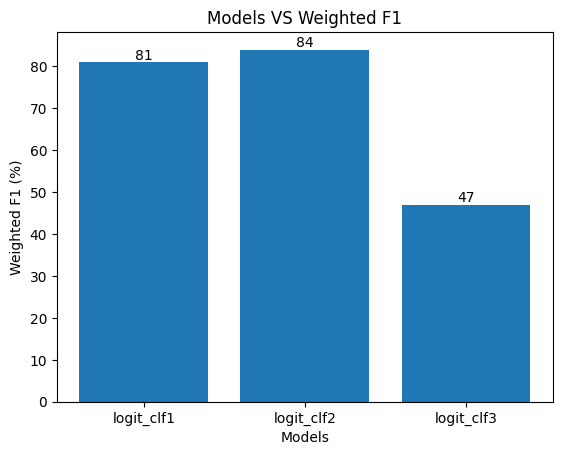

logit_clf1 is logit_clf trained on the original train set.
logit_clf2 is logit_clf with class_weight='balanced' trained on the original train set.
logit_clf3 is logit_clf trained on the full-augmented train set.


In [41]:
bar_x_lst = ['logit_clf1', 
             "logit_clf2", 
             'logit_clf3']

bar_y_lst = [cross_val_dict1[ 'test_score'][-1], cross_val_dict2[ 'test_score'][-1], cross_val_dict3[ 'test_score'][2]]
bar_y_lst = [int(y * 100 ) for y in bar_y_lst]

legend_txt = '''logit_clf1 is logit_clf trained on the original train set.
logit_clf2 is logit_clf with class_weight='balanced' trained on the original train set.
logit_clf3 is logit_clf trained on the full-augmented train set.'''

bar_obj = plt.bar(bar_x_lst, bar_y_lst)
plt.title('Models VS Weighted F1')
plt.xlabel('Models')
plt.ylabel('Weighted F1 (%)')
plt.bar_label(bar_obj)
plt.savefig("Models_VS_Weighted_F1.png", bbox_inches = 'tight')
plt.show()

print(legend_txt)

# 6. Evaluate the Model

Since the best_logit_clf2 model has the highest weighted f1 score on the validation set (i.e., it is a set from the training set of the original dataset) during training, so such model is promising choise for deploying and needed to evaluate it on the test set of the original dataset.

In [42]:
best_logit_clf2

LogisticRegression(class_weight='balanced', max_iter=200, solver='saga')

In [43]:
print('prep_x_test.shape =', prep_x_test.shape)
print('prep_y_test.shape =', prep_y_test.shape)

prep_x_test.shape = (7887, 36736)
prep_y_test.shape = (7887,)


In [46]:
pred = best_logit_clf2.predict(prep_x_test)
test_f1 = f1_score(prep_y_test, pred, average='weighted')
test_acc = accuracy_score(prep_y_test, pred)

print('test_f1 =', test_f1)
print('test_acc =', test_acc)

test_f1 = 0.839542626934062
test_acc = 0.8384683656650184
